# Example of Point Process Decoder

For use in point process decoding (sometimes I also use point process filter), we need the following format of inputs:
- Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin
- It should be noted that point process decoding is for **binary-valued spike trains**. Hence, the time bins should be very small to gurantee that most intervals have no more than one spike.
- The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In this example, we load Matlab data that contains 
- The spike times of all neurons. In Matlab, "spike_times" is a cell of size "number of neurons" x 1. Within spike_times{i} is a vector containing all the spike times of neuron i.
- A continuous stream of the output variables. In this example, we are aiming to decode velocity. In Matlab, "vels" is a matrix of size "number of recorded time points" x 2 (x and y velocities were recorded) that contains the x and y velocity components at all time points. "vel_times" is a vector that states the time at all recorded time points. 

We will put this data in the format described above, with the help of the functions "bin_spikes" and "bin_output" that are in the file "preprocessing_funcs.py"

This example is similar to those shown in "Examples_kf_decoder." However, there is some preprocessing is different for **Point Process**, so we have made a separate notebook. It should be noted that a **small time bin** should be used to obtain point process observation.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Check the intervals and visualize point process observation
5. Run the point process decoders
6. Plot example decoded outputs
7. Evaluating the goodness of fit

- State-space model with Gaussian approximation (Kalman FILTER with Point Process) [Link][1]
- State-space model with sequential Monte Carlo (Particle FILTER with Point Process) [Link][2]

[1]: https://direct.mit.edu/neco/article/16/5/971/6831/Dynamic-Analysis-of-Neural-Encoding-by-Point
[2]: https://direct.mit.edu/neco/article/21/10/2894/7426/Sequential-Monte-Carlo-Point-Process-Estimation-of]

## Import packages and functions

In [2]:
###Import standard packages###
import numpy as np
from scipy import io
import matplotlib.pyplot as plt


###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
%matplotlib inline

## Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=0&preview=s1_data_raw.mat)

It was recorded by Raeed Chowdhury from Lee Miller's lab at Northwestern.

In [3]:
###Load Data###
folder='data/' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/' 
data=io.loadmat(folder+'s1_data_raw.mat')
spike_times=data['spike_times'] #Load spike times of all neurons
vels=data['vels'] #Load x and y velocities
vel_times=data['vel_times'] #Load times at which velocities were recorded

## User Inputs

In [4]:
dt=.01 #Size of time bins (in seconds)
t_start=vel_times[0] #Time to start extracting data - here the first time velocity was recorded
t_end=vel_times[-1] #Time to finish extracting data - here the last time velocity was recorded
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.

In [5]:
print("t start %.2fs and t end %.2fs"%(t_start,t_end))
t_end = 500
print("selected: t start %.2fs and t end %.2fs"%(t_start,t_end))


t start 1.17s and t end 3068.16s
selected: t start 1.17s and t end 500.00s


## Put data in binned format

In [6]:
#When loading the Matlab cell "spike_times", Python puts it in a format with an extra unnecessary dimension
#First, we will put spike_times in a cleaner format: an array of arrays
spike_times=np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])

In [7]:
###Preprocessing to put spikes and output in bins###

#Bin neural data using "bin_spikes" function
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
vels_binned=bin_output(vels,vel_times,dt,t_start,t_end,downsample_factor)

## Check the number of spikes in each intervals

In [8]:
print("Neural data shape:(%d,%d)"%(neural_data.shape[0],neural_data.shape[1]))
no_spike = np.sum(neural_data==0)
one_spike = np.sum(neural_data==1)
more_than_one_spike = np.sum(neural_data>1)
num_intervals = neural_data.shape[0]*neural_data.shape[1]

# check the ratio
print("{:.1%} intervals have no more than one spike".format(1-more_than_one_spike/num_intervals))

Neural data shape:(49882,52)
99.3% intervals have no more than one spike


## Eventplot for spikes

Number of Spike of each neuron in 1000 points:  [ 10.   8.  14.  73.  15. 115.  64.  96.  72.  90.]


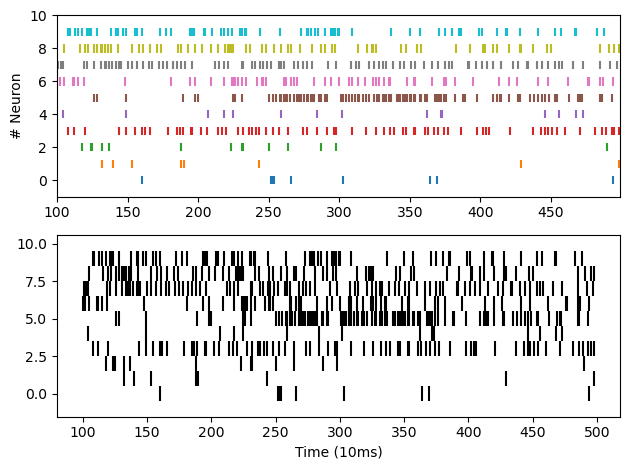

In [12]:
t_window = np.arange(100,500,1)
demo_data = neural_data[t_window,0:10]
num_neu = demo_data.shape[1]
colors1 = [f'C{i}' for i in range(num_neu)]
colors2 = 'black'

lineoffsets1 = list(range(num_neu))
linelengths1 = np.ones((num_neu),dtype=int)*0.5
lineoffsets2 = list(range(num_neu))
linelengths2 = 1

tt = np.arange(0,1000,1)
print("Number of Spike of each neuron in 1000 points: ", np.sum(demo_data.T,axis=1))

fig, axs = plt.subplots(2, 1)
for i in range(num_neu):
    event_data = t_window[0] + np.where(demo_data[:,i]>0)
    # the first parameter of eventplot is position
    # position: the occur time
    # but how is there any better way to process different length position array?
    axs[0].eventplot(event_data, color=colors1[i], lineoffsets=lineoffsets1[i], linelengths=linelengths1[i])
    axs[1].eventplot(event_data, color=colors2, lineoffsets=lineoffsets2[i], linelengths=linelengths2)

axs[0].set_xlim(t_window[0],t_window[-1])
axs[0].set_ylabel("# Neuron")
axs[1].set_xlabel("Time (10ms)")
fig.tight_layout()


## Decoding

## Save Data

In [6]:
# import pickle

# data_folder='' #FOLDER YOU WANT TO SAVE THE DATA TO

# with open(data_folder+'example_data_s1.pickle','wb') as f:
#     pickle.dump([neural_data,vels_binned],f)